## 예제 4-2 셰익스피어 작품의 문장 생성을 LSTM으로 학습하기

LSTM으로 셰익스피어 작품 흉내 내기를 실습한다. 모형은 입력층과 2개의 은닉층 그리고 출력층으로 구성된다. 은닉층의 노드 수는 32, 서열 길이는 50, 가중치 클리핑은 5로 설정하였다.

In [1]:
import os
import numpy as np
import tensorflow as tf

In [2]:
#-------------------------------------------------
# 데이터 불러오기
#-------------------------------------------------
#os.chdir("C:\\Users\\admin\\Dropbox\\저서\텐서플로_딥러닝\\RNN_tensorflow")
raw_data = open('./input.txt', 'r').read() # input.txt 예제 데이터
# 계산 시간 때문에 일부만 사용
raw_data = raw_data[:200000]

In [3]:
print(type(raw_data))
print(len(raw_data))
print(raw_data[0:100])

<class 'str'>
200000
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [4]:
# 전체 문자 수
n_samples = len(raw_data)
# 고유한 문자
unique_chars = list(set(raw_data));
# 문자를 정수로 변환하는 딕셔너리
char_to_int = { ch:i for i,ch in enumerate(unique_chars) }
# 정수를 문자로 변환하는 딕셔너리
int_to_char = { i:ch for i,ch in enumerate(unique_chars) }
# 고유한 문자 수
n_unique_chars = len(unique_chars)

In [5]:
print(n_samples)
print(n_unique_chars)

200000
62


In [6]:
# 입력층의 노드 수(입력 크기) = 원-핫 벡터 크기
input_dim = n_unique_chars
# 출력층의 노드 수 = 고유한 문자 수
num_classes = n_unique_chars

In [39]:
#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 은닉층 크기: 32
# 미니배치 크기: 100
# 반복 수: 200
# 학습률: 0.1
# Gradient Clipping에 사용할 임곗값: 2
batch_size = 100
seq_len = 62 # 한 번에 입력되는 서열 길이
hidden_size = 32 # 은닉층 노드 수
learning_rate = 0.05
grad_clip = 5 # Gradient Clipping에 사용할 임곗값
nepochs = 50 # 반복 수
# 배치 개수
num_batches = int(len(raw_data)/(batch_size * seq_len)) # 40

In [40]:
# 데이터 - (배치 크기*배치 개수)
data = raw_data[:num_batches*batch_size*seq_len]
# 데이터를 정수로 변환
data = np.array([char_to_int[n] for n in data]);

In [41]:
# 입력과 목표 데이터 설정
xdata = data
ydata = np.copy(data)
ydata[:-1] = xdata[1:]
ydata[-1] = xdata[0]

In [42]:
# 배치 개수*배치 크기*서열 길이 = (?, 100, 32)
#x_batches = np.split(xdata.reshape(batch_size, -1),num_batches, 1)
#x_batches = np.asarray(x_batches)
#x_batches.shape
dataset = tf.data.Dataset.from_tensor_slices((xdata, ydata)).batch(seq_len, drop_remainder=True)
dataset = dataset.batch(batch_size, drop_remainder=True)

In [43]:
print(type(dataset))
print(dataset)
print(list(dataset.as_numpy_iterator())[0])

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<BatchDataset shapes: ((100, 62), (100, 62)), types: (tf.int32, tf.int32)>
(array([[34, 51, 57, ..., 25, 60, 60],
       [52, 53, 53, ...,  6,  1, 57],
       [31, 48,  3, ..., 48, 51, 49],
       ...,
       [ 1, 12, 48, ..., 26, 24, 60],
       [28,  6,  1, ..., 20,  1, 31],
       [48,  6, 12, ..., 12, 53, 53]]), array([[51, 57, 30, ..., 60, 60, 52],
       [53, 53,  4, ...,  1, 57, 31],
       [48,  3, 31, ..., 51, 49,  1],
       ...,
       [12, 48, 31, ..., 24, 60, 28],
       [ 6,  1, 31, ...,  1, 31, 48],
       [ 6, 12, 48, ..., 53, 53, 31]]))


In [44]:
# 입력 데이터 플레이스 홀더 설정([batch_size, seq_len])
#X = tf.placeholder(tf.int32, shape = [None, None])
# 목표 데이터 플레이스 홀더 설정([batch_size*seq_len, n_unique_chars])
#Y = tf.placeholder(tf.int32, shape = [None, None])
#state_batch_size = tf.placeholder(tf.int32, shape=[]) # Training: 100, Sampling: 1

In [45]:
model = tf.keras.Sequential()
# 각 문자를 원-핫 코딩이 아닌 hidden_size 크기의 숫자 벡터로 변환
# 즉 n_unique_chars -> hidden_size
model.add(tf.keras.layers.Embedding(n_unique_chars, hidden_size))
# 드롭아웃 사용
model.add(tf.keras.layers.SpatialDropout1D(0.2))
# LSTM으로 cell을 정의한다.
model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True)) # returns a sequence of vectors of dimension 32
# 은닉층 추가
model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True)) # returns a sequence of vectors of dimension 32
# 은닉층 추가
model.add(tf.keras.layers.LSTM(hidden_size)) # return a single vector of dimension 32

# 은닉층의 값으로 출력을 만듦
# 은닉층의 결과를 완전 연결층을 통하여 분류
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [46]:
model.build(input_shape=(batch_size, seq_len))

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          1984      
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, None, 32)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 62)                2046      
Total params: 28,990
Trainable params: 28,990
Non-trainable params: 0
__________________________________________________

In [52]:
# 손실함수
#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = model, labels = Y))
def loss(labels, predictions):
    #return tf.losses.sparse_categorical_crossentropy(labels, predictions, from_logits=True)
    return tf.losses.categorical_crossentropy(labels, predictions, from_logits=True)

In [49]:
# 변수 선언
#tvars = tf.trainable_variables()
# 기울기 클리핑
#grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), grad_clip)

In [53]:
# 옵티마이저
#optim = tf.train.AdamOptimizer(learning_rate)
# 기울기 적용 (optim.AdamOptimizer().minimize() 대신 사용됨)
#train_step = optim.apply_gradients(zip(grads, tvars))
model.compile(optimizer=tf.optimizers.Adam(), loss=loss)

In [ ]:
#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
steps_per_epoch = n_samples // seq_len // batch_size # 200000 / 100 / 50 = 40
history = model.fit(dataset.repeat(), epochs=nepochs, steps_per_epoch=steps_per_epoch)

## 예제 4-2 셰익스피어 작품의 문장 생성을 LSTM으로 학습하기 (2)

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
#-------------------------------------------------
# 데이터 불러오기
#-------------------------------------------------
raw_data = open('./input.txt', 'r').read() # input.txt 예제 데이터
# 계산 시간 때문에 일부만 사용
raw_data = raw_data[:200000]

In [3]:
print(type(raw_data))
print(len(raw_data))
print(raw_data[0:100])

<class 'str'>
200000
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [4]:
# 전체 문자 수
n_samples = len(raw_data)
# 고유한 문자
unique_chars = list(set(raw_data));
# 문자를 정수로 변환하는 딕셔너리
char_to_int = { ch:i for i,ch in enumerate(unique_chars) }
# 정수를 문자로 변환하는 딕셔너리
int_to_char = { i:ch for i,ch in enumerate(unique_chars) }
# 고유한 문자 수
n_unique_chars = len(unique_chars)

In [5]:
print(n_samples)
print(n_unique_chars)

200000
62


In [6]:
# 입력층의 노드 수(입력 크기) = 원-핫 벡터 크기
input_dim = n_unique_chars
# 출력층의 노드 수 = 고유한 문자 수
num_classes = n_unique_chars

In [7]:
#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 은닉층 크기: 32
# 미니배치 크기: 100
# 반복 수: 200
# 학습률: 0.1
# Gradient Clipping에 사용할 임곗값: 2
batch_size = 100
seq_len = 50 # 한 번에 입력되는 서열 길이
hidden_size = 32 # 은닉층 노드 수
learning_rate = 0.05
grad_clip = 5 # Gradient Clipping에 사용할 임곗값
nepochs = 50 # 반복 수
# 배치 개수
num_batches = int(len(raw_data)/(batch_size * seq_len)) # 40

In [8]:
# 데이터 - (배치 크기*배치 개수)
data = raw_data[:num_batches*batch_size*seq_len]
# 데이터를 정수로 변환
data = np.array([char_to_int[n] for n in data]);

In [9]:
# 입력과 목표 데이터 설정
xdata = data
ydata = np.copy(data)
ydata[:-1] = xdata[1:]
ydata[-1] = xdata[0]

In [10]:
# 배치 개수*배치 크기*서열 길이 = (?, 100, 32)
#x_batches = np.split(xdata.reshape(batch_size, -1),num_batches, 1)
#x_batches = np.asarray(x_batches)
#x_batches.shape
dataset = tf.data.Dataset.from_tensor_slices((xdata, ydata)).batch(seq_len, drop_remainder=True)
dataset = dataset.batch(batch_size, drop_remainder=True)

In [11]:
print(type(dataset))
print(dataset)
print(list(dataset.as_numpy_iterator())[0])

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<BatchDataset shapes: ((100, 50), (100, 50)), types: (tf.int32, tf.int32)>
(array([[10, 40, 60, ..., 13, 20, 60],
       [61, 33, 13, ..., 36, 55, 50],
       [61, 20, 60, ..., 12, 12,  1],
       ...,
       [40, 39, 25, ..., 18, 55, 50],
       [14, 12, 12, ..., 13, 61,  4],
       [40, 25, 39, ..., 13, 15, 15]]), array([[40, 60,  0, ..., 20, 60, 61],
       [33, 13, 61, ..., 55, 50, 61],
       [20, 60, 13, ..., 12,  1, 15],
       ...,
       [39, 25, 61, ..., 55, 50, 14],
       [12, 12, 10, ..., 61,  4, 40],
       [25, 39, 15, ..., 15, 15, 55]]))


In [31]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(n_unique_chars, hidden_size))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
model.add(tf.keras.layers.Dense(n_unique_chars))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          1984      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 32)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dense (Dense)                (None, None, 62)          2046      
Total params: 28,990
Trainable params: 28,990
Non-trainable params: 0
____________________________________________________

In [32]:
def loss(labels, predictions):
    return tf.losses.sparse_categorical_crossentropy(labels, predictions, from_logits=True)

In [33]:
#model.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy')
model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate, clipvalue=grad_clip), loss=loss)

In [34]:
steps_per_epoch = n_samples // seq_len // batch_size # 200000 / 100 / 50 = 40
history = model.fit(dataset.repeat(), epochs=nepochs, steps_per_epoch=steps_per_epoch)

Train for 40 steps
Epoch 1/50
40/40 [==============================] - 4s 95ms/step - loss: 3.3201
Epoch 2/50
40/40 [==============================] - 0s 9ms/step - loss: 2.9024
Epoch 3/50
40/40 [==============================] - 0s 8ms/step - loss: 2.6203
Epoch 4/50
40/40 [==============================] - 0s 9ms/step - loss: 2.5088
Epoch 5/50
40/40 [==============================] - 0s 9ms/step - loss: 2.3928
Epoch 6/50
40/40 [==============================] - 0s 9ms/step - loss: 2.3019
Epoch 7/50
40/40 [==============================] - 0s 9ms/step - loss: 2.2436
Epoch 8/50
40/40 [==============================] - 0s 9ms/step - loss: 2.1990
Epoch 9/50
40/40 [==============================] - 0s 9ms/step - loss: 2.1639
Epoch 10/50
40/40 [==============================] - 0s 9ms/step - loss: 2.1225
Epoch 11/50
40/40 [==============================] - 0s 9ms/step - loss: 2.0936
Epoch 12/50
40/40 [==============================] - 0s 9ms/step - loss: 2.0738
Epoch 13/50
40/40 [==========

In [29]:
for k, v in history.history.items():
    print (k, v)

loss [3.807945889234543, 3.3841592490673067, 3.332049036026001, 3.318163937330246, 3.3099526345729826, 3.3042814671993255, 3.3009482741355898, 3.2990593135356905, 3.2977127015590666, 3.295790636539459, 3.289447271823883, 3.2577452480793, 3.193133521080017, 3.125380641222, 3.054002982378006, 2.977961426973343, 2.9002927124500273, 2.8365539789199827, 2.7893757104873655, 2.752096915245056, 2.7202860355377196, 2.695071017742157, 2.6742831110954284, 2.6564983665943145, 2.640400010347366, 2.625147503614426, 2.6105785965919495, 2.597229462862015, 2.5852218151092528, 2.5733910739421844, 2.562173104286194, 2.5515903353691103, 2.540703761577606, 2.5303552448749542, 2.520364999771118, 2.510841292142868, 2.5013031363487244, 2.491811752319336, 2.48232581615448, 2.473926991224289, 2.464893102645874, 2.4575085043907166, 2.449648863077164, 2.4425165832042692, 2.4351768791675568, 2.428162342309952, 2.4207546412944794, 2.414255440235138, 2.407371884584427, 2.3999757528305055]


Text(0, 0.5, 'Losses')

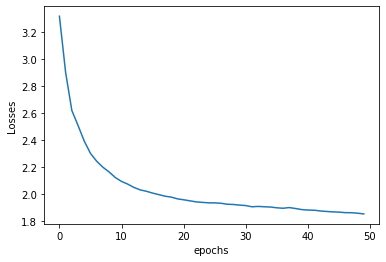

In [35]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
ax.set_xlabel('epochs')
ax.set_ylabel('Losses')

In [36]:
DATA_DIR = "data" # where you download the source code
CHECKPOINT_DIR = os.path.join(DATA_DIR, "checkpoints") # where we will save the weights
checkpoint_file = os.path.join(CHECKPOINT_DIR, 'model_ex4-2')
model.save_weights(checkpoint_file)

In [ ]:
# create generative model using the trained model so far
gen_model = CharGenModel(n_unique_chars, hidden_size, hidden_size)
gen_model.load_weights(checkpoint_file)
gen_model.build(input_shape=(1, seq_len))

In [38]:
gen_model = tf.keras.Sequential()
gen_model.add(tf.keras.layers.Embedding(n_unique_chars, hidden_size))
gen_model.add(tf.keras.layers.SpatialDropout1D(0.2))
gen_model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
gen_model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
gen_model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
gen_model.add(tf.keras.layers.Dense(n_unique_chars))
gen_model.load_weights(checkpoint_file)
gen_model.build(input_shape=(1, seq_len))

In [39]:
# 생성할 문장의 길이
generated_text_len = 200  
# 시작 문자를 't'로 지정.
generated_text = 't' 
# RNN의 최초 state값을 0으로 초기화.
#state = sess.run(cell.zero_state(1, tf.float32))
gen_model.reset_states()
gen_model.build(input_shape=(1, seq_len))

In [40]:
text_generated = []
input = [char_to_int[s] for s in generated_text]
input = tf.expand_dims(input, 0)
for i in range(generated_text_len):
    preds = gen_model(input)
    # 차원이 1인 차원을 모두 제거한다
    preds = tf.squeeze(preds, 0)
    # predict char returned by model
    pred_id = tf.random.categorical(preds, num_samples=1)[-1, 0].numpy()
    text_generated.append(int_to_char[pred_id])
    # pass the prediction as the next input to the model
    input = tf.expand_dims([pred_id], 0)
        
print(generated_text + "".join(text_generated))

thor wanthede u de:
OMandeatiseendescelloog.
CERCI IUS:
Tegee lsead melrre y hewase!
Titprndosthayowuscllstalanlrwider; t. tharisth harloouss y w f Ifer!
Wouyswechearchachedowur RTer INas,
Aes?
Dotr
Wo


## 예제 4-3 AR(2) 모형 학습하기

이번에는 AR(2) 모형을 따르는 시계열을 예측하는 예제를 다룬다.

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [96]:
#--------------------------------------------------
# 길이가 100인 data(#AR(2) with a1=0.5; a2=-0.3) 만들기
#--------------------------------------------------
k=100
x=np.random.normal(0,1,k); 
e=np.random.normal(0,1,k)
a1=0.5 
a2=-0.3

x[2]=a1*x[1]+a2*x[0]+e[2]
for i in range(2,k):
    x[i]=a1*x[i-1]+a2*x[i-2]+e[i]

# 표준화    
x=(x-min(x))/(max(x)-min(x))

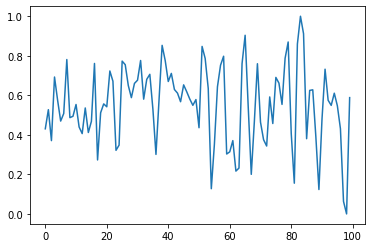

In [97]:
plt.plot(x)

In [98]:
#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 은닉층 크기: 16
# 미니배치 크기: 1
# 반복 수: 1000
# 학습률 :0.0005
# 서열길이 10
hidden_size =16 
learning_rate = 0.0005 
nepochs = 1000 
seq_len=10 
batch_size=1

In [99]:
#------------------------------------------
# 시계열 훈련에 적합한 데이터 만들기
# 0~9 : input, 10: target
# 1~10 : input, 11: target
# ...
# 89~98 : input, 99: target
#-------------------------------------------
dataX = []; dataY = []
for i in range(k-seq_len):
    tempX=x[i:i+seq_len]
    dataX.append(tempX)
    tempY=x[i+seq_len]
    dataY.append(tempY)

In [100]:
print(len(dataX))
print(len(dataY))
print(dataX[0])
print(dataY[0])
print(dataX[1])
print(dataY[1])

90
90
[0.43055999 0.52736801 0.37074749 0.69252689 0.57601954 0.46964616
 0.50797712 0.78099058 0.48708346 0.49385851]
0.5535442950499825
[0.52736801 0.37074749 0.69252689 0.57601954 0.46964616 0.50797712
 0.78099058 0.48708346 0.49385851 0.5535443 ]
0.4396940898841052


In [154]:
dataset = tf.data.Dataset.from_tensor_slices((dataX, dataY)).batch(batch_size, drop_remainder=True)
#dataset = tf.data.Dataset.from_tensor_slices((dataX, dataY)).batch(seq_len, drop_remainder=True)
#dataset = dataset.batch(batch_size, drop_remainder=True)

In [155]:
print(dataset)

<BatchDataset shapes: ((1, 10), (1,)), types: (tf.float64, tf.float64)>


In [147]:
# 훈련자료 크기    
sample_size=np.array(dataY).shape[0] # 90

In [122]:
# 플레이스 홀더
#X = tf.placeholder(tf.float32, shape=[None,seq_len,1])  # (None, 10, 1)
#Y = tf.placeholder(tf.float32, [None,1])                # (None, 1)

# 가중치와 편의 변수 
#W = tf.Variable(tf.random_normal([hidden_size, 1]))     # (16, 1)
#b = tf.Variable(tf.random_normal([1]))                  # (1)

# LSTM 셀 정의 
#cell1 = tf.nn.rnn_cell.BasicLSTMCell(hidden_size)       # (16)
#cell2 = tf.nn.rnn_cell.BasicLSTMCell(hidden_size)       # (16)
# 은닉층 2개
#multi_cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2])
#output0, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)  

# 서열의 마지막 출력 값
#output1 = tf.transpose(output0, [1, 0, 2]); 
#outputs = output1[-1]   
#Y_pred= tf.matmul(outputs, W) + b


In [134]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True, input_shape=(10, 1)))
#model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
model.add(tf.keras.layers.LSTM(hidden_size))
model.add(tf.keras.layers.Dense(1, activation=None))

In [ ]:
#model.build(input_shape=(batch_size, seq_len))

In [135]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 10, 16)            1152      
_________________________________________________________________
lstm_16 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


In [136]:
# 손실함수와 옵티마이저
#cost = tf.reduce_sum(tf.square(Y_pred - Y))  
#optim = tf.train.AdamOptimizer(learning_rate).minimize(cost)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss='MSE')

In [148]:
#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
#steps_per_epoch = len(texts) // seq_length // batch_size = 345739 // 100 // 64 = 54
#model.fit(dataset.repeat(), epochs=nepochs, steps_per_epoch=1)
model.fit(dataset, epochs=nepochs)

ValueError: in converted code:

    D:\ProgramData\Miniconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py:677 map_fn
        batch_size=None)
    D:\ProgramData\Miniconda3\lib\site-packages\tensorflow_core\python\keras\engine\training.py:2410 _standardize_tensors
        exception_prefix='input')
    D:\ProgramData\Miniconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_utils.py:582 standardize_input_data
        str(data_shape))

    ValueError: Error when checking input: expected lstm_15_input to have shape (10, 1) but got array with shape (1, 10)


## 예제 4-4 워드 임베딩 실습

In [1]:
# 필요한 라이브러리 부름
import tensorflow as tf
import numpy as np
from keras.utils import np_utils 
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [81]:
# 매개변수 지정
# 학습률: 0.1
# 반복 수: 10000
# 임베딩 차원: 2
# 윈도우 크기: 1
learning_rate=0.1
nepochs=1000
embedding_dim=2
window_size = 1

In [3]:
# 워드 임베딩에 적용할 문장
#text = 'Arthur is a famous king He is a brave man The king is royal Elizabeth is the royal  queen She is a beautiful woman'
text ="King is a brave man Queen is a beautiful woman"

In [4]:
# 소문자로 변환
text = text.lower()

In [5]:
# 간단한 불용어와 문자 그리고 숫자 제거
word_seq = []
for word in text.split():
    if ((word != '.') & (word not in '0123456789')& (word not in ['a','is', 'the'] )):
        word_seq.append(word)

In [6]:
print(word_seq)

['king', 'brave', 'man', 'queen', 'beautiful', 'woman']


In [7]:
# 고유한 단어들로 만든 집합
unique_words = set(word_seq) 
n_unique_words = len(unique_words) 

In [8]:
print(unique_words)
print(n_unique_words)

{'king', 'beautiful', 'brave', 'woman', 'man', 'queen'}
6


In [9]:
# 단어와 정수 매핑
word_to_int = {w: i for i, w in enumerate(unique_words)}
int_to_word = {i: w for i, w in enumerate(unique_words)}

In [10]:
# 훈련에 사용될 데이터 [input, target] 만듬              
data = []
for i in range(1, len(word_seq) - 1):
    # [input, target] = [neighbors, target]
    target = word_seq[i]
    neighbor=[]
    for j in range(window_size):
        neighbor.append(word_seq[i - j-1])
        neighbor.append(word_seq[i +  j+ 1])

    for w in neighbor:
        data.append([w, target])

In [11]:
print(data)

[['king', 'brave'], ['man', 'brave'], ['brave', 'man'], ['queen', 'man'], ['man', 'queen'], ['beautiful', 'queen'], ['queen', 'beautiful'], ['woman', 'beautiful']]


In [12]:
# 원-핫 벡터로 변환
x_train = [] 
y_train = [] 

for w in data:
    x_train.append(np_utils.to_categorical(word_to_int[w[0]] , n_unique_words))
    y_train.append(np_utils.to_categorical(word_to_int[w[1]] , n_unique_words))

In [13]:
# 넘파이 arrary로 변환
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [14]:
print(x_train, "\n")
print(y_train)

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]] 

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [15]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(6, drop_remainder=True)

In [16]:
print(dataset)

<BatchDataset shapes: ((6, 6), (6, 6)), types: (tf.float32, tf.float32)>


In [17]:
for i in dataset:
    print(i)
    break

(<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)>)


In [18]:
# 훈련에 사용될 placeholder
#X = tf.placeholder(tf.float32, shape=(None, n_unique_words)) # (None, 6)
#Y = tf.placeholder(tf.float32, shape=(None, n_unique_words)) # (None, 6)

# 입력층과 은닉층의 가중치
#W1 = tf.Variable(tf.random_normal([n_unique_words, embedding_dim])) # (6,2)
#b1 = tf.Variable(tf.random_normal([embedding_dim])) # (2)
# 은닉층 값
#hidden_representation = tf.add(tf.matmul(X,W1), b1)
# 은닉층과 출력층의 가중치
#W2 = tf.Variable(tf.random_normal([embedding_dim, n_unique_words])) # (2, 6)
#b2 = tf.Variable(tf.random_normal([n_unique_words])) # (6)

# 출력값
#prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_representation, W2), b2))

In [82]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2, input_shape=(6,), activation=None))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

In [87]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 18        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [88]:
# 손실함수 
#cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(prediction), reduction_indices=[1]))
def loss(labels, predictions):
    return tf.reduce_mean(-tf.reduce_sum(labels * tf.math.log(predictions), axis=1))

In [89]:
# optimizer 정의
#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy_loss)
model.compile(optimizer=tf.optimizers.SGD(learning_rate=learning_rate), loss=loss)

In [90]:
history = model.fit(dataset, epochs=nepochs, verbose=0)

Text(0, 0.5, 'Losses')

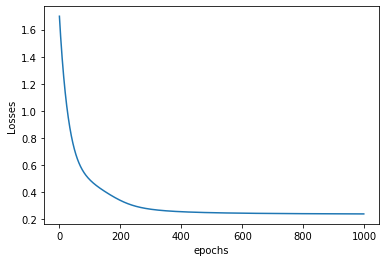

In [91]:
fig, ax = plt.subplots()
_ = plt.plot(history.history['loss'])
ax.set_xlabel('epochs')
ax.set_ylabel('Losses')

In [92]:
# 임베딩 결과
W1 = model.get_weights()[0] # 첫 번째 층의 가중치
b1 = model.get_weights()[1] # 첫 번째 층의 bias

In [93]:
vectors = W1 + b1
print(vectors)

[[ 2.6590095  -2.125996  ]
 [ 1.1518244   1.3135844 ]
 [-0.9255158  -1.8148738 ]
 [ 0.9056039  -1.2620358 ]
 [ 2.150806   -0.31324035]
 [-0.77656615 -2.068821  ]]


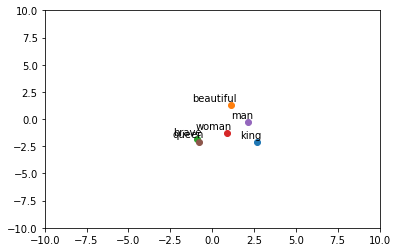

In [94]:
fig, ax = plt.subplots()

#임베딩 그림
for  i, label in enumerate(word_to_int):
    x, y = vectors[i]
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
    
plt.show()